# This is part 1 of a 2 part notebook that covers data exploration and feature creation.

# The data was too heavy for models to be fit in the same notebook and so modeling, validation, and submissions were done in another notebook to save computational resources.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [10]:
print("pandas version:",pd.__version__)
print("numpy version:",np.__version__)
print("xgb version:",xgb.__version__)

pandas version: 0.22.0
numpy version: 1.14.1
xgb version: 0.7.post3


In [2]:
data_dir = "../data/"

item_categories = pd.read_csv(data_dir+"item_categories.csv")
items = pd.read_csv(data_dir+"items.csv")
shops = pd.read_csv(data_dir+"shops.csv")
sales_train = pd.read_csv(data_dir+"sales_train.csv.gz")

In [3]:
def rmse(y1,y2):
    return np.sqrt(np.mean((y1-y2)**2))

def evaluate(df):
    df.plot(kind="scatter",x="predict",y="item_cnt_day")
    plt.show()
    print("rmse:",rmse(df.item_cnt_day,df.predict))

In [4]:
print(item_categories.head())
print(item_categories.shape)
print(items.head())
print(items.shape)
print(shops.head())
print(shops.shape)
print(sales_train.head())
print(sales_train.shape)

        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4
(84, 2)
                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  
(22170, 3)
                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК 

In [5]:
sales_train.date = pd.to_datetime(sales_train.date,format="%d.%m.%Y")
sales_train.set_index("date", inplace=True)

In [6]:
sales_month = sales_train.groupby([pd.Grouper(freq="M"),"shop_id","item_id"]).agg({"item_cnt_day":"sum","item_price":"mean"})
sales_month = sales_month.reset_index()

sales_month["month"] = sales_month.date.dt.month
sales_month = sales_month.merge(items, on="item_id")

sales_month

,date,shop_id,item_id,item_cnt_day,item_price,month,item_name,item_category_id
0,2013-01-31,0,32,6.0,221.000000,1,1+1,40
1,2013-01-31,1,32,7.0,221.000000,1,1+1,40
2,2013-01-31,3,32,3.0,349.000000,1,1+1,40
3,2013-01-31,4,32,2.0,349.000000,1,1+1,40
4,2013-01-31,6,32,8.0,349.000000,1,1+1,40
5,2013-01-31,7,32,1.0,349.000000,1,1+1,40
6,2013-01-31,13,32,6.0,221.000000,1,1+1,40
7,2013-01-31,14,32,3.0,349.000000,1,1+1,40
8,2013-01-31,15,32,3.0,349.000000,1,1+1,40
9,2013-01-31,16,32,7.0,349.000000,1,1+1,40


# Exploratory Data Analysis

In [7]:
sales_month

,date,shop_id,item_id,item_cnt_day,item_price,month,item_name,item_category_id
0,2013-01-31,0,32,6.0,221.000000,1,1+1,40
1,2013-01-31,1,32,7.0,221.000000,1,1+1,40
2,2013-01-31,3,32,3.0,349.000000,1,1+1,40
3,2013-01-31,4,32,2.0,349.000000,1,1+1,40
4,2013-01-31,6,32,8.0,349.000000,1,1+1,40
5,2013-01-31,7,32,1.0,349.000000,1,1+1,40
6,2013-01-31,13,32,6.0,221.000000,1,1+1,40
7,2013-01-31,14,32,3.0,349.000000,1,1+1,40
8,2013-01-31,15,32,3.0,349.000000,1,1+1,40
9,2013-01-31,16,32,7.0,349.000000,1,1+1,40


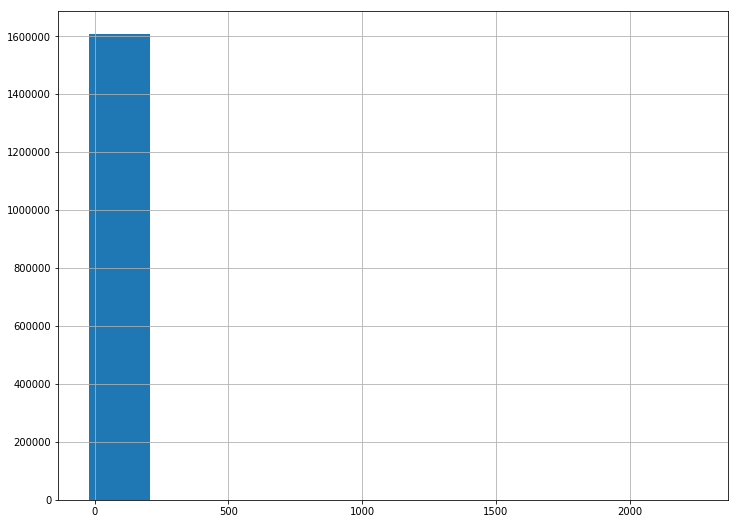

In [8]:
sales_month.item_cnt_day.hist(figsize=(12,9))
plt.show()

In [9]:
sales_month.item_cnt_day.describe()

count    1.609124e+06
mean     2.267200e+00
std      8.649882e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.253000e+03
Name: item_cnt_day, dtype: float64

We can observe that most sales for the month fall around 0.

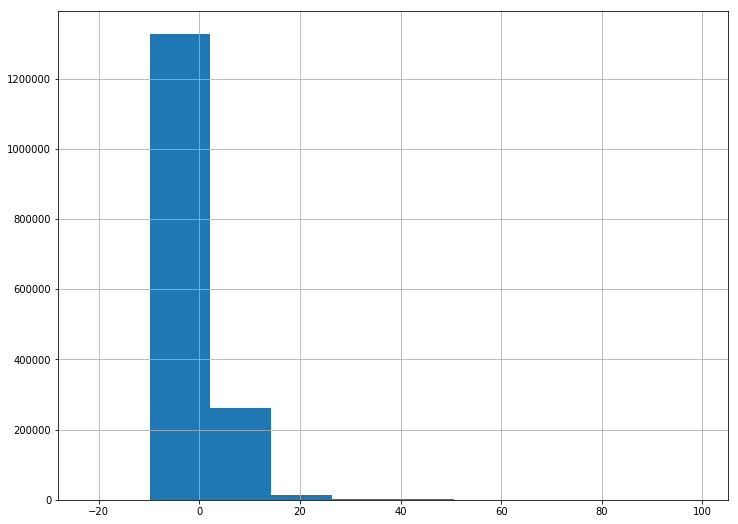

In [10]:
sales_month[sales_month.item_cnt_day < 100].item_cnt_day.hist(figsize=(12,9))
plt.show()

 Looking at monthly sales, we can see that the bulk of the data of falls around 0 and there are only a few cases where sales pass 20. Almost all of the data passing 20 are outliers.

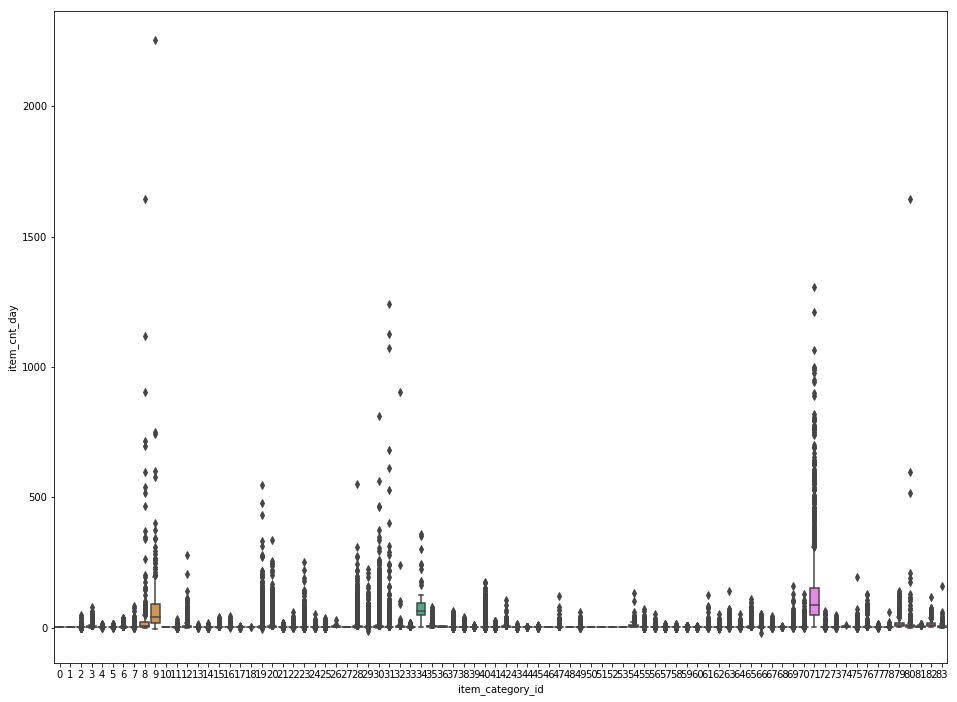

In [13]:
plt.figure(figsize=(16,12))
sns.boxplot(x="item_category_id",y="item_cnt_day",data=sales_month)
plt.show()

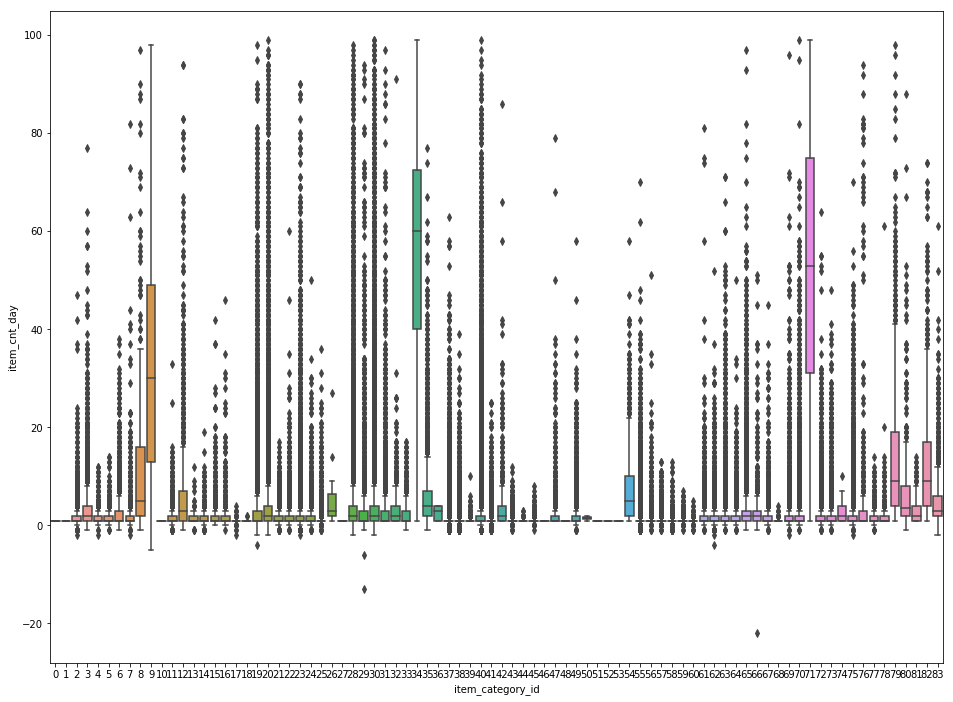

In [15]:
plt.figure(figsize=(16,12))
sns.boxplot(x="item_category_id",y="item_cnt_day",data=sales_month[sales_month.item_cnt_day < 100])
plt.show()

 Checking the 90th percentile of each item also shows us that the mean is close to 1.

In [18]:
month_90_percentile = sales_month.groupby("item_id").agg({"item_cnt_day": lambda x: np.percentile(x, .9)})

In [19]:
month_90_percentile.describe()

,item_cnt_day
count,21807.000000
mean,1.031895
std,1.692285
min,-12.568000
25%,1.000000
50%,1.000000
75%,1.000000
max,215.000000


We can see that there are just 3 of 84 item categories where the bulk of the target value lies above 20. Nearly all items have a 90th percentile of 1 sale for the entire month.

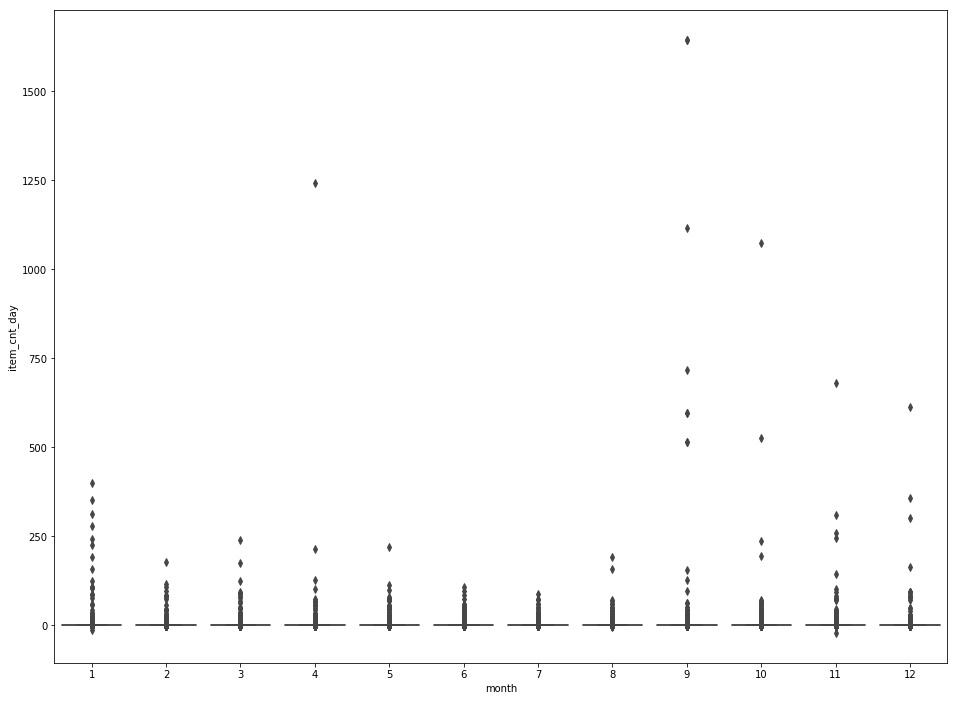

In [20]:
month_90_percentile_byitem = sales_month.groupby(["item_id","month"]).agg({"item_cnt_day": lambda x: np.percentile(x, .9)}).reset_index()
plt.figure(figsize=(16,12))
sns.boxplot(x="month",y="item_cnt_day",data=month_90_percentile_byitem)
plt.show()

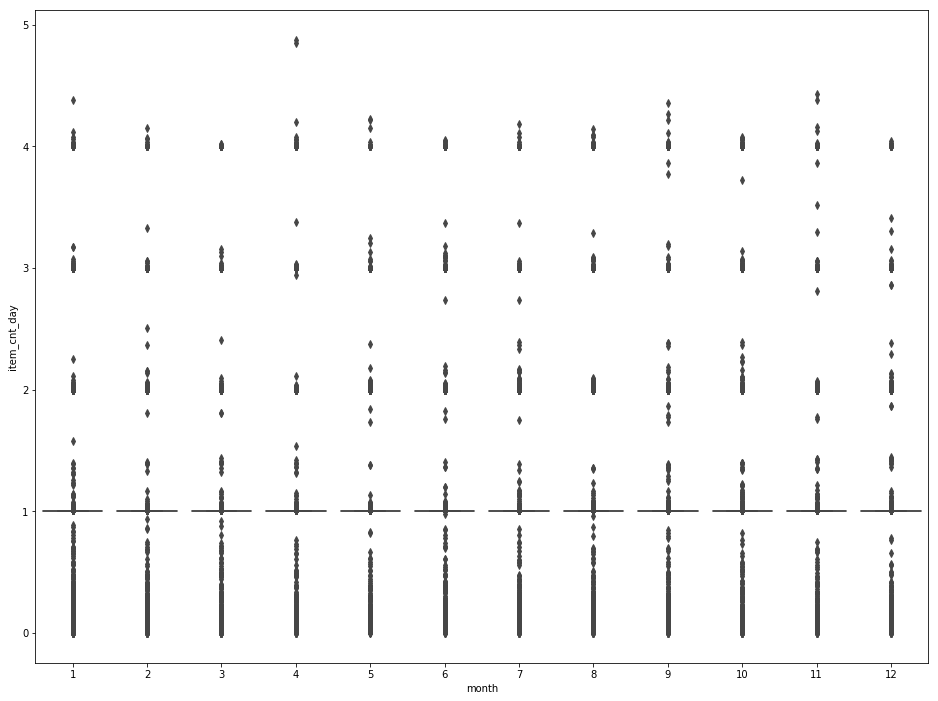

In [21]:
plt.figure(figsize=(16,12))
sns.boxplot(x="month",y="item_cnt_day",data=month_90_percentile_byitem[(month_90_percentile_byitem.item_cnt_day < 5)&(month_90_percentile_byitem.item_cnt_day >= 0)])
plt.show()

It looks like this does not really change by month as the boxplots of monthly sales by item remain centered around 1 across all 12 months, so when we fit our models to the data we will want to make sure that the fact that most items sold close to 0 is reflected in the data.

# Naive Modeling

First let's create a baseline by using naive forecasts from the previous month and the previous year. To calculate these, simply forecast the number of sales from the last month or the last year as the sales for the target month. The data ranges from January 2013 to October 2015, with the test period being November 2015.

Let's begin by using October 2015 as a validation month and comparing it to the test score.

In [22]:
print(sales_month.date.min(), sales_month.date.max())

2013-01-31 00:00:00 2015-10-31 00:00:00


In [22]:
test = pd.read_csv(data_dir + "test.csv.gz")

test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [24]:
X_valid = sales_month[(sales_month.month==10)&(sales_month.date.dt.year==2015)].merge(test,how="right") \
    [["shop_id","item_id","item_cnt_day"]]
X_valid.item_cnt_day.fillna(0, inplace=True)
X_valid.rename(columns={"item_cnt_day":"actual"}, inplace=True)
X_valid.actual = X_valid.actual.clip(0,20)

naive_forecast_month_valid = X_valid.merge(sales_month[(sales_month.month==9)&(sales_month.date.dt.year==2015)] \
                                           [["shop_id","item_id","item_cnt_day"]],how="left") \

naive_forecast_month_valid.item_cnt_day.fillna(0, inplace=True)
naive_forecast_month_valid.item_cnt_day = naive_forecast_month_valid.item_cnt_day.clip(0,20)
print("rmse(1 month before forecast):", rmse(naive_forecast_month_valid.actual, naive_forecast_month_valid.item_cnt_day))

naive_forecast_year_valid = X_valid.merge(sales_month[(sales_month.month==10)&(sales_month.date.dt.year==2014)] \
                                         [["shop_id","item_id","item_cnt_day"]],how="left") \

naive_forecast_year_valid.item_cnt_day.fillna(0, inplace=True)
naive_forecast_year_valid.item_cnt_day = naive_forecast_year_valid.item_cnt_day.clip(0,20)
print("rmse(1 year before forecast):", rmse(naive_forecast_year_valid.actual, naive_forecast_year_valid.item_cnt_day))

rmse(1 month before forecast): 1.0842820667951134
rmse(1 year before forecast): 1.3509791725102536


In [17]:
naive_forecast_month = test.merge(sales_month[(sales_month.month==10)&(sales_month.date.dt.year==2015)],how="left",on=["shop_id","item_id"])
naive_forecast_month.fillna(0, inplace=True)
naive_forecast_month.item_cnt_day = naive_forecast_month.item_cnt_day.clip(0,20)

out1 = naive_forecast_month[["ID","item_cnt_day"]].rename(columns={"item_cnt_day":"item_cnt_month"})
out1.to_csv("submission1.csv",index=False)

naive_forecast_year = test.merge(sales_month[(sales_month.month==11)&(sales_month.date.dt.year==2014)],how="left",on=["shop_id","item_id"])
naive_forecast_year.fillna(0, inplace=True)
naive_forecast_year.item_cnt_day = naive_forecast_year.item_cnt_day.clip(0,20)

out2 = naive_forecast_year[["ID","item_cnt_day"]].rename(columns={"item_cnt_day":"item_cnt_month"})
out2.to_csv("submission2.csv",index=False)

These 2 forecasts achieved scores of 1.16 and 1.6 respectively, which reflects the fact that using the value from 1 month previous also achieved a better a validation score. This seems to model the test distribution quite well.

# Train, Validation, Test Distributions

In [26]:
print(rmse(X_valid.actual,np.zeros(X_valid.shape[0])))
print(rmse(X_valid.actual,X_valid.actual.clip(0,1)))

out3 = out1.copy()
out3.item_cnt_month = out3.item_cnt_month.clip(0,1)
out3.to_csv("submission3.csv",index=False)

1.1194361325694113
0.9356713413428194


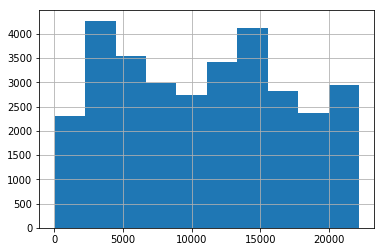

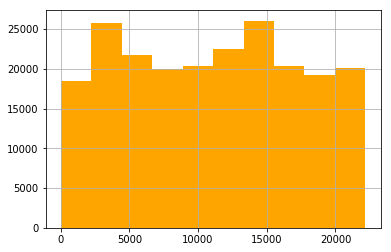

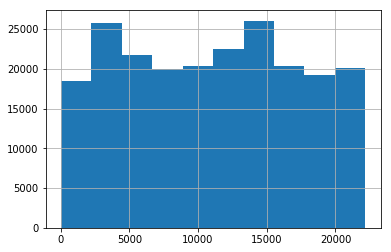

In [27]:
sales_month[(sales_month.month==10)&(sales_month.date.dt.year==2015)].item_id.hist()
plt.show()
test.item_id.hist(color="orange")
plt.show()
X_valid.item_id.hist()
plt.show()


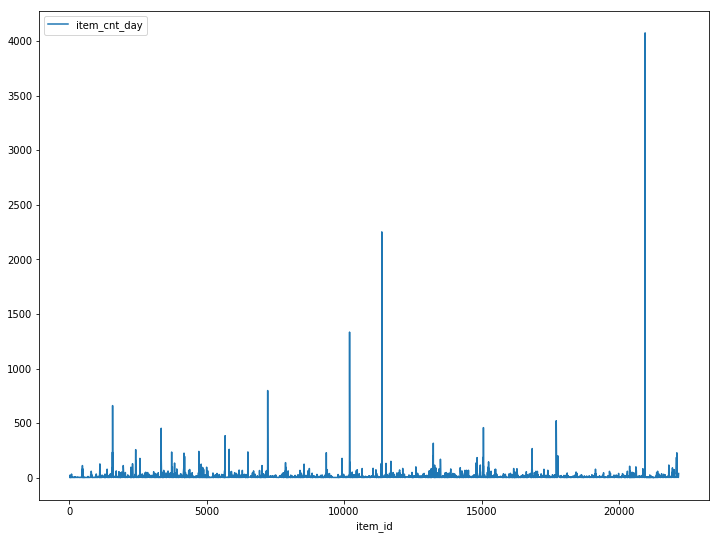

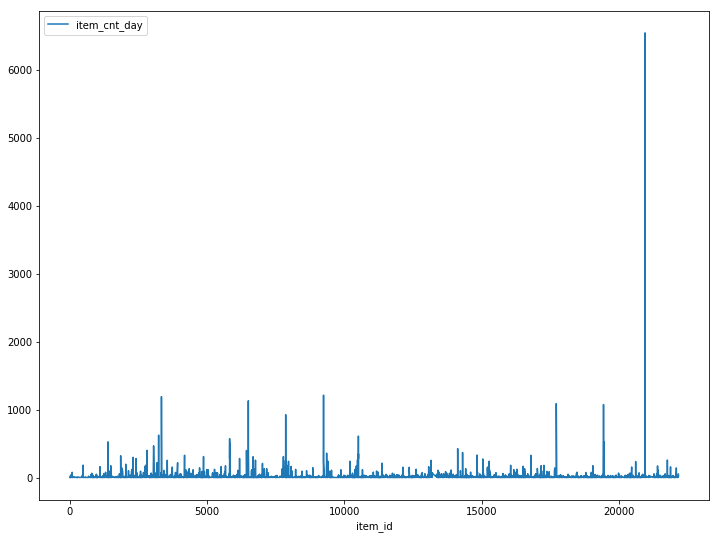

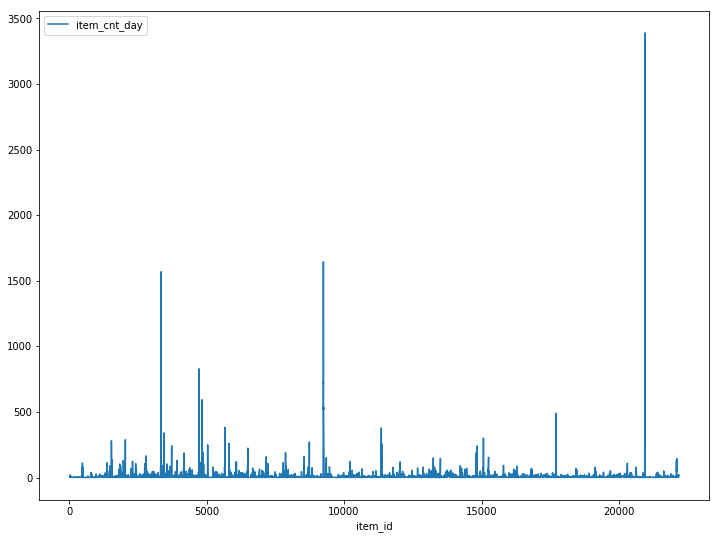

In [28]:
sales_month[(sales_month.month==10)&(sales_month.date.dt.year==2015)].groupby("item_id").agg({"item_cnt_day":"sum"}).plot(figsize=(12,9))
plt.show()
sales_month[(sales_month.month==10)&(sales_month.date.dt.year==2014)].groupby("item_id").agg({"item_cnt_day":"sum"}).plot(figsize=(12,9))
plt.show()
sales_month[(sales_month.month==9)&(sales_month.date.dt.year==2015)].groupby("item_id").agg({"item_cnt_day":"sum"}).plot(figsize=(12,9))
plt.show()

In [29]:
plt.show()

Since we filled in the distribution, the distribution is the same regardless of validation/test. Without filling in the validation set, we can see that the distribution is slightly different in shape than from the test distribution. Mostly however, there is a massive different in the frequency of item appearances. This is likely due to 0s not being included in the original data, so we should fill these in when modeling.

In [23]:
item_ids = sales_month.item_id.unique()
missing_items = [x for x in test.item_id.unique() if x not in item_ids]
missing_items

[5320,
 5268,
 5826,
 3538,
 3571,
 3604,
 3407,
 3408,
 3405,
 3984,
 8551,
 8822,
 8823,
 8824,
 8890,
 10779,
 9767,
 8355,
 8354,
 6729,
 6731,
 6732,
 6152,
 6153,
 6742,
 7782,
 7862,
 6743,
 6335,
 13559,
 13804,
 13402,
 14647,
 14832,
 14959,
 2327,
 1732,
 2322,
 2323,
 2326,
 2569,
 2966,
 21467,
 20400,
 20401,
 20836,
 1580,
 1585,
 1246,
 1437,
 2328,
 2427,
 2325,
 3022,
 1193,
 1252,
 1386,
 1884,
 1885,
 1577,
 3627,
 4412,
 3271,
 3349,
 13558,
 13310,
 13338,
 12890,
 13805,
 13309,
 12568,
 13275,
 13251,
 13303,
 13250,
 13249,
 13232,
 13242,
 14648,
 19773,
 18913,
 21397,
 21708,
 16051,
 16141,
 16193,
 15553,
 1284,
 5269,
 6730,
 3338,
 4060,
 11974,
 7728,
 7729,
 7926,
 8549,
 8826,
 5812,
 5025,
 9972,
 11762,
 7669,
 13263,
 13264,
 8993,
 7727,
 18174,
 19219,
 6863,
 12117,
 13209,
 13273,
 14521,
 7592,
 7607,
 7646,
 6903,
 8545,
 5322,
 4156,
 5843,
 11385,
 13271,
 10028,
 10203,
 16139,
 22022,
 3760,
 3908,
 640,
 639,
 140,
 249,
 428,
 10507,
 1

We can see that there are a lot of missing items in the test set so we're going to eventually want to create summary statistics for what are hopefully similar items in order to make predictions for items that we have never seen before.

# Initial Modeling

Let's expand out our data to reflect the fact that most items have sales of 0, so that the models can fit the data correctly. Items will be expanded out by their shop id, their item id, and then the date block that they appear in.

In [24]:
sales_train.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date,,,,,
2013-01-02,0,59,22154,999.00,1.0
2013-01-03,0,25,2552,899.00,1.0
2013-01-05,0,25,2552,899.00,-1.0
2013-01-06,0,25,2554,1709.05,1.0
2013-01-15,0,25,2555,1099.00,1.0


In [25]:
from itertools import product

In [26]:
idx_cols = ["shop_id","item_id","date_block_num"]

grid = []
for block_num in sales_train.date_block_num.unique():
    cur_shops = sales_train[sales_train.date_block_num == block_num]["shop_id"].unique()
    cur_items = sales_train[sales_train.date_block_num == block_num]["item_id"].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])), dtype="int32"))
    
grid = pd.DataFrame(np.vstack(grid), columns=idx_cols, dtype=np.int32)

gb = sales_train.groupby(idx_cols, as_index=False).agg({"item_cnt_day":"sum"}).rename(columns={"item_cnt_day":"target"})

train_data = grid.merge(gb, how="left",on=idx_cols).fillna(0)
train_data.sort_values(["date_block_num","shop_id","item_id"], inplace=True)

train_data.head()

,shop_id,item_id,date_block_num,target
139255,0,19,0,0.0
141495,0,27,0,0.0
144968,0,28,0,0.0
142661,0,29,0,0.0
138947,0,32,0,6.0


In [38]:
train_data.shape

(10913850, 8)

# Feature Creation

Now let's also calculate some mean encodings that we can use as features. Simple mean encodings will be captured here by calculating the mean encoding for each item over the training period, which is all the data up to the last October. Items that are missing mean encodings will have their values filled with .3343.

In [39]:
train_data = train_data.merge(items, how="left")

In [40]:
def split_train_test(x):
    return x[x.date_block_num < 33], x[x.date_block_num == 33], x[x.date_block_num == 34]

In [41]:
train, _, _ = split_train_test(train_data)

In [42]:
item_id_mean_enc = train.groupby("item_id").target.mean()
train_data["item_target_enc"] = train_data["item_id"].map(item_id_mean_enc)
train_data.item_target_enc.fillna(0.3343, inplace=True)

train_data[["target","item_target_enc"]].corr()

,target,item_target_enc
target,1.000000,0.481776
item_target_enc,0.481776,1.000000


In [43]:
test["date_block_num"] = 34
test = test.merge(items, how="left")
test.head()

,ID,shop_id,item_id,date_block_num,item_name,item_category_id,item_target_enc,item_cat_enc
0,0,5,5037,34,"NHL 15 [PS3, русские субтитры]",19,2.051071,0.764905
1,1,5,5320,34,ONE DIRECTION Made In The A.M.,55,0.334300,0.224683
2,2,5,5233,34,"Need for Speed Rivals (Essentials) [PS3, русск...",19,1.774809,0.764905
3,3,5,5232,34,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,1.329412,0.674349
4,4,5,5268,34,"Need for Speed [PS4, русская версия]",20,0.334300,1.957818


In [44]:
item_id_mean_enc = train.groupby("item_id").target.mean()
train_data["item_target_enc"] = train_data["item_id"].map(item_id_mean_enc)
train_data.item_target_enc.fillna(0.3343, inplace=True)

train_data[["target","item_target_enc"]].corr()

,target,item_target_enc
target,1.000000,0.481776
item_target_enc,0.481776,1.000000


Let's also calculate categorical encodings as some items are brand new in the test set.

In [45]:
item_cat_mean_enc = train.groupby("item_category_id").target.mean()
train_data["item_cat_enc"] = train_data["item_category_id"].map(item_cat_mean_enc)

train_data[["target","item_cat_enc"]].corr()

,target,item_cat_enc
target,1.000000,0.385853
item_cat_enc,0.385853,1.000000


In [46]:
train_data.head()

,shop_id,item_id,date_block_num,target,item_name,item_category_id,item_target_enc,item_cat_enc
0,0,19,0,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,0.022222,0.254509
1,0,27,0,0.0,"007 Legends [PS3, русская версия]",19,0.056834,0.764905
2,0,28,0,0.0,"007 Legends [PС, Jewel, русская версия]",30,0.141176,1.213606
3,0,29,0,0.0,"007 Legends [Xbox 360, русская версия]",23,0.037383,0.674349
4,0,32,0,6.0,1+1,40,1.342412,0.254509


In [47]:
test["item_target_enc"] = test["item_id"].map(item_id_mean_enc)
test.item_target_enc.fillna(0.3343, inplace=True)
test["item_cat_enc"] = test["item_category_id"].map(item_cat_mean_enc)
test.head()

,ID,shop_id,item_id,date_block_num,item_name,item_category_id,item_target_enc,item_cat_enc
0,0,5,5037,34,"NHL 15 [PS3, русские субтитры]",19,2.051071,0.764905
1,1,5,5320,34,ONE DIRECTION Made In The A.M.,55,0.334300,0.224683
2,2,5,5233,34,"Need for Speed Rivals (Essentials) [PS3, русск...",19,1.774809,0.764905
3,3,5,5232,34,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,1.329412,0.674349
4,4,5,5268,34,"Need for Speed [PS4, русская версия]",20,0.334300,1.957818


In [48]:
train, valid, _ = split_train_test(train_data)

Now that we have mean encodings, lets see how our model performs.

In [ ]:
import xgboost as xgb

In [ ]:
predictors = ["shop_id", "item_id", "item_category_id", "item_target_enc", "item_cat_enc", "date_block_num"]

In [78]:
model = xgb.XGBRegressor()

model.fit(train[predictors], train.target)
predict_valid = model.predict(valid[predictors])

1.0949817951030416

In [79]:
rmse(valid.target.clip(0,20), predict_valid.clip(0,20))

1.0949817951030416

That's not bad, it's better than the naive forecast from simply using the last month's value. But we need to do better so let's try adding some lagged values as well.

In [49]:
train_data.head()

,shop_id,item_id,date_block_num,target,item_name,item_category_id,item_target_enc,item_cat_enc
0,0,19,0,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,0.022222,0.254509
1,0,27,0,0.0,"007 Legends [PS3, русская версия]",19,0.056834,0.764905
2,0,28,0,0.0,"007 Legends [PС, Jewel, русская версия]",30,0.141176,1.213606
3,0,29,0,0.0,"007 Legends [Xbox 360, русская версия]",23,0.037383,0.674349
4,0,32,0,6.0,1+1,40,1.342412,0.254509


In [50]:
data = pd.concat([train_data,test],axis=0, ignore_index=True)

In [51]:
lag_data = data.pivot_table(index="date_block_num", columns=["shop_id","item_id"], values="target", fill_value=0)
lag_data.head()

shop_id           0                                                         \
item_id        12    19    27    28    29    30    31    32    33    34      
date_block_num                                                               
0                  0     0     0     0     0     0     0     6     3     0   
1                  0     0     0     0     0    31    11    10     3     0   
2                  0     0     0     0     0     0     0     0     0     0   
3                  0     0     0     0     0     0     0     0     0     0   
4                  0     0     0     0     0     0     0     0     0     0   

shop_id         ...     59                                                  \
item_id         ...  22160 22161 22162 22163 22164 22165 22166 22167 22168   
date_block_num  ...                                                          
0               ...      0     0     0     0     0     0     0     0     0   
1               ...      0     0     0     0     0     0     0     0     0   
2               ...      0     0     0     0     0     0     0     0     0   
3               ...      0     0     0     0     0     0     0     0     0   
4               ...      0     0     0     0     0     0     0     0     0   

shop_id               
item_id        22169  
date_block_num        
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 1152307 columns]

In [52]:
lags = [1,2,3,4,5,12]
for i in lags:
    data = data.merge(pd.melt(lag_data.shift(i).reset_index(), id_vars="date_block_num", value_name="item_lag{}".format(i)).fillna(-1), how="left")

data.head()

,ID,date_block_num,item_cat_enc,item_category_id,item_id,item_name,item_target_enc,shop_id,target,item_lag1,item_lag2,item_lag3,item_lag4,item_lag5,item_lag12
0,NaN,0,0.254509,40,19,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,0.022222,0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,NaN,0,0.764905,19,27,"007 Legends [PS3, русская версия]",0.056834,0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,NaN,0,1.213606,30,28,"007 Legends [PС, Jewel, русская версия]",0.141176,0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,NaN,0,0.674349,23,29,"007 Legends [Xbox 360, русская версия]",0.037383,0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,NaN,0,0.254509,40,32,1+1,1.342412,0,6.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [39]:
train, valid, _ = split_train_valid(train_data)

predictors = [x for x in train.columns if x not in ["target","item_name"]]
print(predictors)

model2 = xgb.XGBRegressor()

model2.fit(train[predictors], train.target)
predict_valid = model2.predict(valid[predictors])

['shop_id', 'item_id', 'date_block_num', 'item_category_id', 'item_target_enc', 'item_cat_enc', 'item_lag1', 'item_lag2', 'item_lag3', 'item_lag4', 'item_lag5', 'item_lag12']


In [40]:
rmse(valid.target.clip(0,20), predict_valid.clip(0,20))

1.057371718847418

That's much better! Let's also try adding encodings and lags for total shop sales, total item sales, and total category sales. Note that these features can only be used as lags as they would leak information for the block they are calculated in.

In [53]:
shop_enc = (train.shop_id.value_counts() / train.shop_id.value_counts().sum()).reset_index().rename(columns={"index":"shop_id","shop_id":"shop_enc"}).set_index("shop_id").shop_enc
data["shop_enc"] = data.shop_id.map(shop_enc)

In [54]:
lagged_features = ["total_shop_sales", "total_item_sales", "total_cat_sales"]
total_shop_sales = train.groupby(["date_block_num","shop_id"]).agg({"target":"sum"}).rename(columns={"target":"total_shop_sales"}).reset_index()
total_item_sales = train.groupby(["date_block_num","item_id"]).agg({"target":"sum"}).rename(columns={"target":"total_item_sales"}).reset_index()
total_cat_sales = train.groupby(["date_block_num","item_category_id"]).agg({"target":"sum"}).rename(columns={"target":"total_cat_sales"}).reset_index()

In [55]:
data = data.merge(total_shop_sales, how="left").merge(total_item_sales, how="left").merge(total_cat_sales, how="left")

In [56]:
lags = [1,2,3,4,5,12]
for f in lagged_features:
    print("processing feature:", f)
    lag_data = data.pivot_table(index="date_block_num", columns=["shop_id","item_id"], values=f, fill_value=0)
    for i in lags:
        print("processing lag:", i)
        data = data.merge(pd.melt(lag_data.shift(i).reset_index(), id_vars="date_block_num", value_name="{}_lag{}".format(f,i)).fillna(-1), how="left")
    
data.head()

processing feature: total_shop_sales
processing lag: 1
processing lag: 2
processing lag: 3
processing lag: 4
processing lag: 5
processing lag: 12
processing feature: total_item_sales
processing lag: 1
processing lag: 2
processing lag: 3
processing lag: 4
processing lag: 5
processing lag: 12
processing feature: total_cat_sales
processing lag: 1
processing lag: 2
processing lag: 3
processing lag: 4
processing lag: 5
processing lag: 12


,ID,date_block_num,item_cat_enc,item_category_id,item_id,item_name,item_target_enc,shop_id,target,item_lag1,...,total_item_sales_lag3,total_item_sales_lag4,total_item_sales_lag5,total_item_sales_lag12,total_cat_sales_lag1,total_cat_sales_lag2,total_cat_sales_lag3,total_cat_sales_lag4,total_cat_sales_lag5,total_cat_sales_lag12
0,NaN,0,0.254509,40,19,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,0.022222,0,0.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,NaN,0,0.764905,19,27,"007 Legends [PS3, русская версия]",0.056834,0,0.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,NaN,0,1.213606,30,28,"007 Legends [PС, Jewel, русская версия]",0.141176,0,0.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,NaN,0,0.674349,23,29,"007 Legends [Xbox 360, русская версия]",0.037383,0,0.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,NaN,0,0.254509,40,32,1+1,1.342412,0,6.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


Unfortunately the data is now too heavy to do anything with, including modeling, so modeling is done in a separate notebook. Please check the 2nd notebook, model tuning, for the modeling process, validation results, and final submission results.

In [58]:
data.to_hdf("../data/processed_data.h5", key="data")